In [1]:
import os
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import OrderedDict
import math
import random
from glob import glob
import json

import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.optim import lr_scheduler
from torchvision import datasets
from torch.utils.tensorboard import SummaryWriter

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

%matplotlib inline

In [2]:
# Get COLAB runtime
if 'COLAB_TPU_ADDR' in os.environ:
    DEVICE = 'TPU'
elif os.environ['COLAB_GPU']=='1':
    DEVICE = 'GPU'
else:
    DEVICE = 'CPU'
print('Using', DEVICE)

Using TPU


In [3]:
# If TPU, import xla
if DEVICE=='TPU':
    import torch_xla
    import torch_xla.core.xla_model as xm

In [4]:
# Set default device
if DEVICE=='TPU':
    device = xm.xla_device()
elif DEVICE=='GPU':
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [5]:
IMAGE_SIZE = 224
BANNERHEIGHT = 12
ROTATION_ANGLE = 10

NORM = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [6]:
data_dir = '../data/raw/airlinersnet/'
batch_size = 16

feature_extract=True

In [7]:
def load_data(data_dir):
    # Data loading and normalization for training

    rad = math.radians(ROTATION_ANGLE)
    c = math.cos(rad)
    s = math.sin(rad)
    
    l = IMAGE_SIZE/2

    x = l*c-l*s
    y = l*s+l*c
    rotpad = math.ceil(max(x,y)-l)

    data_transforms = {
        "train": transforms.Compose(
            [
                transforms.Pad((0,0,0,-BANNERHEIGHT)), # Crop banner from bottom edge of image
                transforms.Resize(240),
                transforms.RandomResizedCrop(IMAGE_SIZE),
                transforms.RandomHorizontalFlip(),
                transforms.Pad(rotpad, padding_mode='reflect'), # Mirror boundary to avoid empty corners of rotated image
                transforms.RandomRotation(ROTATION_ANGLE),
                transforms.CenterCrop(IMAGE_SIZE),
                transforms.ToTensor(),
                transforms.Normalize(*NORM)
            ]
        ),
        "valid": transforms.Compose(
            [
                transforms.Pad((0,0,0,-BANNERHEIGHT)),
                transforms.Resize(256),
                transforms.CenterCrop(IMAGE_SIZE),
                transforms.ToTensor(),
                transforms.Normalize(*NORM)
            ]
        ),
        "test": transforms.Compose(
            [
                transforms.Pad((0,0,0,-BANNERHEIGHT)),
                transforms.Resize(256),
                transforms.CenterCrop(IMAGE_SIZE),
                transforms.ToTensor(),
                transforms.Normalize(*NORM)
            ]
        ),
      }

    # Load the datasets with ImageFolder
    image_datasets = {x:datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'valid', 'test']}

    # Dataloaders
    dataloaders = {x:torch.utils.data.DataLoader(image_datasets[x], batch_size = batch_size, shuffle=True, num_workers=4) for x in ['train', 'valid', 'test']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}
    return image_datasets, dataloaders, dataset_sizes


In [8]:

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(NORM[0])
    std = np.array(NORM[1])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    



In [11]:
def init_model():
	model_transfer = models.densenet161(pretrained=True)

	# Freeze training for all "features" layers
	for param in model_transfer.features.parameters():
		param.requires_grad = False
		
	num_classes = len(image_datasets['train'].class_to_idx)
	input_size = model_transfer.classifier.state_dict()[next(iter(model_transfer.classifier.state_dict()))].size(1)
	hidden_units = int(input_size/2)

	model_transfer.classifier = nn.Sequential(OrderedDict([
								('fc1', nn.Linear(input_size, hidden_units)),
								('relu', nn.ReLU()),
								('drop', nn.Dropout(0.4)),
								('fc2', nn.Linear(hidden_units, num_classes))]))

	model_transfer = model_transfer.to(device)

	return model_transfer
	

In [12]:
# Select correct optimizer step function for runtime
def step(optimizer):
    if DEVICE=='TPU':
        xm.optimizer_step(optimizer, barrier=True) 
    else:
        optimizer.step()

In [14]:
def train(n_epochs, loaders, model, optimizer, criterion, save_path):
	# Tensorboard writer
	writer = SummaryWriter()
	"""returns trained model"""
	writer.flush()
	
	print('Training for {} epochs on {}\n'.format(n_epochs, DEVICE))
	# initialize tracker for minimum validation loss
	valid_loss_min = np.Inf 
	
	losses = {'train':[], 'validation':[]}
	for epoch in range(1, n_epochs+1):
		# initialize variables to monitor training and validation loss
		train_loss = 0.0
		valid_loss = 0.0
		
		###################
		# train the model #
		###################
		model.train()
		for batch_idx, (data, target) in enumerate(loaders['train']):
			# move to default device
			data, target = data.to(device), target.to(device)
			## find the loss and update the model parameters accordingly
			## record the average training loss, using something like
			## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
			optimizer.zero_grad()
			output = model(data)
			loss = criterion(output, target)
			step(optimizer)
			train_loss += ((1/(batch_idx+1))*(loss.data-train_loss))
			
		######################	
		# validate the model #
		######################
		model.eval()
		with torch.no_grad():
			for batch_idx, (data, target) in enumerate(loaders['valid']):
				# move to default device
				data, target = data.to(device), target.to(device)
				output = model(data)
				loss = criterion(output, target)
				valid_loss += ((1/(batch_idx+1))*(loss.data-valid_loss))
				## update the average validation loss

			
		# print training/validation statistics 
		print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
			epoch, 
			train_loss,
			valid_loss
			))
		losses['train'].append(train_loss)
		losses['validation'].append(valid_loss)
		writer.add_scalar("Loss/Train", train_loss, epoch)
		writer.add_scalar("Loss/Valid", valid_loss, epoch)


		## TODO: save the model if validation loss has decreased
		if valid_loss<valid_loss_min:
			print('Saving model', save_path)
			valid_loss_min = valid_loss
			torch.save(model.state_dict(), save_path)
			
	# plotting losses
	plt.plot(losses['train'], label='Training Loss')
	plt.plot(losses['validation'], label='Validation Loss')
	plt.legend()
	_ = plt.ylim()
	
	# return trained model
	return model


In [15]:
def test(loaders, model, criterion):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
		# move to default device
        data, target = data.to(device), target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))



In [16]:
transform = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.CenterCrop(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(*NORM)
    ])

def predict(img_path, model):

    img = Image.open(img_path)

    inputs = transform(img).unsqueeze(dim=0)

    model.eval()

    with torch.no_grad():
        # move to default device
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
    model.train()

    return preds.cpu().numpy()[0]

In [17]:
image_datasets, dataloaders, dataset_sizes = load_data(data_dir)

In [18]:
import json
with open("../src/data/airlinersnet_mapping.json","r") as f:
    cat_to_name = json.load(f)

class_names = [cat_to_name[x] for x in image_datasets['train'].classes]

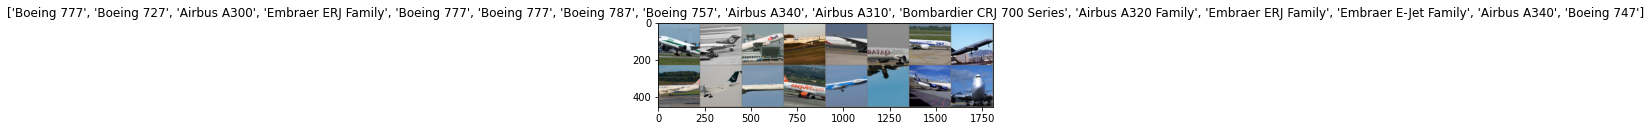

In [19]:

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [20]:
model_transfer = init_model()

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


In [22]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr=0.001, momentum=0.9)

In [ ]:
model_transfer = train(30, dataloaders, model_transfer, optimizer_transfer, criterion_transfer, 'model_densenet_sgd_30_airlinersnet.pt')


In [ ]:
torch.save(model_transfer, 'densenet_full_-30-model.pth')

In [ ]:
model_transfer.load_state_dict(torch.load('model_densenet_sgd_30_airlinersnet.pt'))
model_transfer = torch.load('densenet_full_-30-model.pth')

In [ ]:
test(dataloaders, model_transfer, criterion_transfer)

In [ ]:
def predict_aircraft(img_path):
    idx = predict(img_path, model_transfer)
    return class_names[idx]

In [ ]:
def plot_image(img_path):
    img = cv2.imread(img_path)
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb)
    plt.axis('off')
    plt.show()

def caption_images(img_path):
    print(f"This looks like a: {predict_aircraft(img_path)}")
    plot_image(img_path)
    

In [ ]:
extra_test_img_dir = glob("../data/processed/test_images/*")

In [ ]:
with open("../src/data/airlinersnet_mapping.json","r") as f:
    cat_to_name = json.load(f)


In [ ]:
torch_mapping = image_datasets['train'].class_to_idx

In [ ]:
with open('torch_mapping.json','w') as f:
    json.dump(torch_mapping, f)

In [ ]:
for i in random.sample(list(extra_test_img_dir),3):
    print(predict_aircraft(i))
    plot_image(i)